In [1]:
import plotnine
from math import e
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import scipy.signal as sg
from tqdm import tqdm
import time as clock

%matplotlib inline

In [2]:

def grad_constant(M, alpha, phi, psi, t, y):
    """Returns a scaling vector, used to scale the inconsistent gradients' components
        \t M (float): max signal strength/ gas concentration
        \t alpha (float): max rate of change
        \t phi (float): horizontal shifter, time of midpoint/greatest rate of change
        \t psi (float): vertical shifter, baseline intensity/ gas concentration
        \t t (float): a point in the sampling points of data
        \t y (float): a point in the observed data
    """
    #print(2.0*(M/(1.0+e**(-1.0*alpha*(t-phi)))+psi-y))
    return (2.0*(M/(1.0+e**(-1.0*alpha*(t-phi)))+psi-y))

def grad_M(M, alpha, phi, psi, time, y_series):
    """Returns a scaling vector, used to scale the inconsistent gradients' components
        \t M (float): max signal strength/ gas concentration
        \t alpha (float): max rate of change
        \t phi (float): horizontal shifter, time of midpoint/greatest rate of change
        \t psi (float): vertical shifter, baseline intensity/ gas concentration
        \t t (iterable): the sampling points of data
        \t y_series (iterable): the observed data
    """
    buffer = 0.0
    for i, t in enumerate(time):
        y = y_series[i]
        buffer += (grad_constant(M, alpha, phi, psi, t, y)/(1.0+e**(alpha*(phi-t))))/len(time)
#         print(buffer)
#     print('-----------------------')
    return buffer

def grad_alpha(M, alpha, phi, psi, time, y_series):
    buffer = 0.0
    for i, t in enumerate(time):
        y = y_series[i]    
        buffer += (grad_constant(M, alpha, phi, psi, t, y)*M*((t-phi)*e**(alpha*(phi-t)))
                    /((1+e**(alpha*(phi-t)))**2.0))/len(time)
#     print('-----------------------')
    return buffer

def grad_phi(M, alpha, phi, psi, time, y_series):
    buffer = 0.0
    for i, t in enumerate(time):
        y = y_series[i]    
        buffer += (grad_constant(M, alpha, phi, psi, t, y)*-1.0*alpha*M*e**(alpha*(phi-t))
             /(1+e**(alpha*(phi-t)))**2.0)/len(time)
#     print('-----------------------')
    return buffer

def grad_psi(M, alpha, phi, psi, time, y_series):
    buffer = 0.0
    for i, t in enumerate(time):
        y = y_series[i]
        buffer += grad_constant(M, alpha, phi, psi, t, y)/len(time)
#     print('-----------------------')
    return buffer

In [3]:
def get_cost(M, alpha, phi, psi, time, y_series):
    buffer = 0.0
    for i, t in enumerate(time):
         buffer += (M/(1.0+e**(alpha*(phi-t)))+psi - y_series[i])        
    return buffer

In [13]:
def descend(init_4D_point, time, y_series, descent_speed = .1, iterations = 10000):
    """
        Simple gradient descent
        init_4D_point (tuple) = (M, alpha, phi, psi)
        y (numpy array) = observed data
        t (numpy array) = sampling points for data
        descent speed (float) = step size
        epochs (int) = # of steps, if -1 then gradient descent will loop until minima is found
    """
    curr_M = init_4D_point[0]
    curr_alpha = init_4D_point[1]
    curr_phi = init_4D_point[2]
    curr_psi = init_4D_point[3]
    
    prev_M = 0.0
    prev_alpha = 0.0
    prev_phi = 0.0
    prev_psi = 0.0
    
#     minima_reached = False
    minima = ()
    it = 0
#     print(it)
    
    for i in tqdm(range(iterations)):
        prev_M = float(curr_M)
        prev_alpha = float(curr_alpha)
        prev_phi = float(curr_phi)
        prev_psi = float(curr_psi)
        
        curr_M -= (grad_M(curr_M, curr_alpha, curr_phi, curr_psi, time, y_series) * descent_speed)
        curr_alpha -= (grad_alpha(curr_M, curr_alpha, curr_phi, curr_psi, time, y_series) * descent_speed)
        curr_phi -= (grad_phi(curr_M, curr_alpha, curr_phi, curr_psi, time, y_series) * descent_speed)
        curr_psi -= (grad_psi(curr_M, curr_alpha, curr_phi, curr_psi, time, y_series) * descent_speed)
        
#         print('\r'+str(iteration)+':', (curr_M, curr_alpha, curr_phi, curr_psi))
        
        it += 1
        
        minima = (curr_M, curr_alpha, curr_phi, curr_psi)
        
#         if(get_cost(prev_M, prev_alpha, prev_phi, prev_psi, time, y_series)<
#            get_cost(curr_M, curr_alpha, curr_phi, curr_psi, time, y_series)
#           or i == (iterations-1)):
#             minima_reached = True
#             minima = (prev_M, prev_alpha, prev_phi, prev_psi)
            
    
    return minima


In [5]:
def gradient_descent(init_4D_point, time, y_series, epochs = 10, lifeline = 10000):
    minima = init_4D_point
    for i in range(epochs):
        print("Epoch: ",i)
        clock.sleep(.25)
        precision = 10**(-1*(i+1))
        minima = descend(minima, time, y_series, descent_speed = precision, iterations = lifeline)
    return minima

4.000000002032367


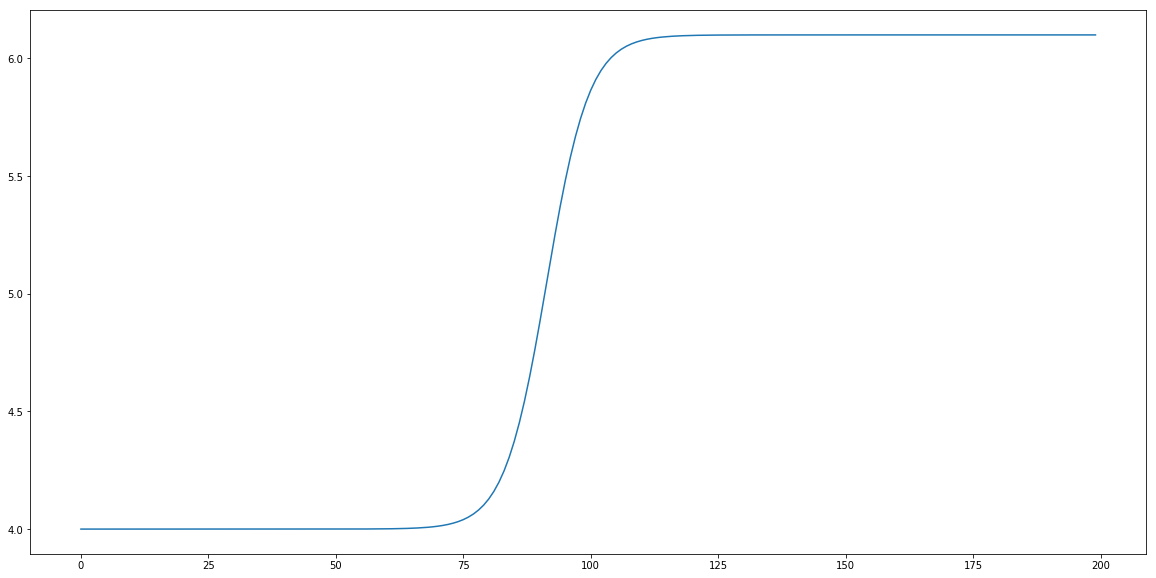

In [6]:
sample_x = np.linspace(0, 100, 200)
sample_y = []

for i, data in enumerate(sample_x):
    sample_y.append(2.10/(1+e**(-.4782*(data - 45.917)))+4)

print(sample_y[5])

plt.figure(figsize=(20,10))
plt.plot(sample_y)


In [14]:
descended_tuple = descend((2.01,.451,42.115,3),sample_x, sample_y, iterations = 10000)
print(descended_tuple)

100%|██████████| 10000/10000 [00:14<00:00, 695.53it/s]


(2.1000488207888544, 0.4781704422800685, 45.905993215496245, 3.999742985103647)


In [7]:
def logistic_curve(constant_tuple, time):
    out_y = []
    for i, data in enumerate(time):
        out_y.append(constant_tuple[0]/(1+e**(-1*constant_tuple[1]*(data - constant_tuple[2])))+constant_tuple[3])
    return out_y

In [8]:
compare_curve = logistic_curve(descended_tuple, sample_x)
plt.figure(figsize = (20,10))
plt.plot(sample_y, linewidth=7)
plt.plot(compare_curve, linewidth = 4)
plt.savefig("epochs10000")
plt.show()

NameError: name 'descended_tuple' is not defined

4.9686452379403155e-05
6408


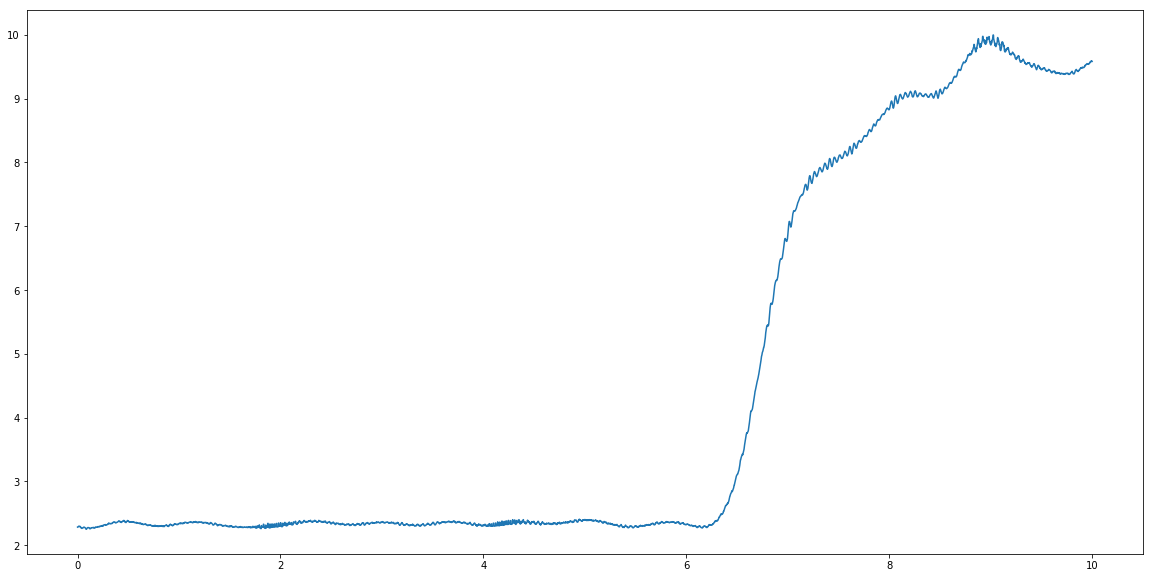

In [22]:
to_regress = np.loadtxt('example_reg.txt', delimiter='\n', dtype=np.float64)[100:-50]
to_regress = sg.resample(to_regress, len(to_regress))/max(to_regress)*10
regress_x = np.linspace(0, 10, len(to_regress))

max_roc = max(np.gradient(to_regress[100:-100]))*regress_x[1]
print(max_roc)

midpoint = np.argmax(np.gradient(to_regress[100:-100]))+100
print(midpoint)

plt.figure(figsize=(20,10))
plt.plot(regress_x,to_regress)



In [25]:
example_descent = gradient_descent((10,max_roc,regress_x[midpoint],7), regress_x, to_regress, lifeline = 10000, epochs = 2)
print(example_descent)

Epoch:  0


100%|██████████| 10000/10000 [09:05<00:00, 18.32it/s]


Epoch:  1


100%|██████████| 10000/10000 [08:32<00:00, 19.52it/s]

(7.020701021264266, 3.7570121488532338, 6.913758017610268, 2.295569388291186)


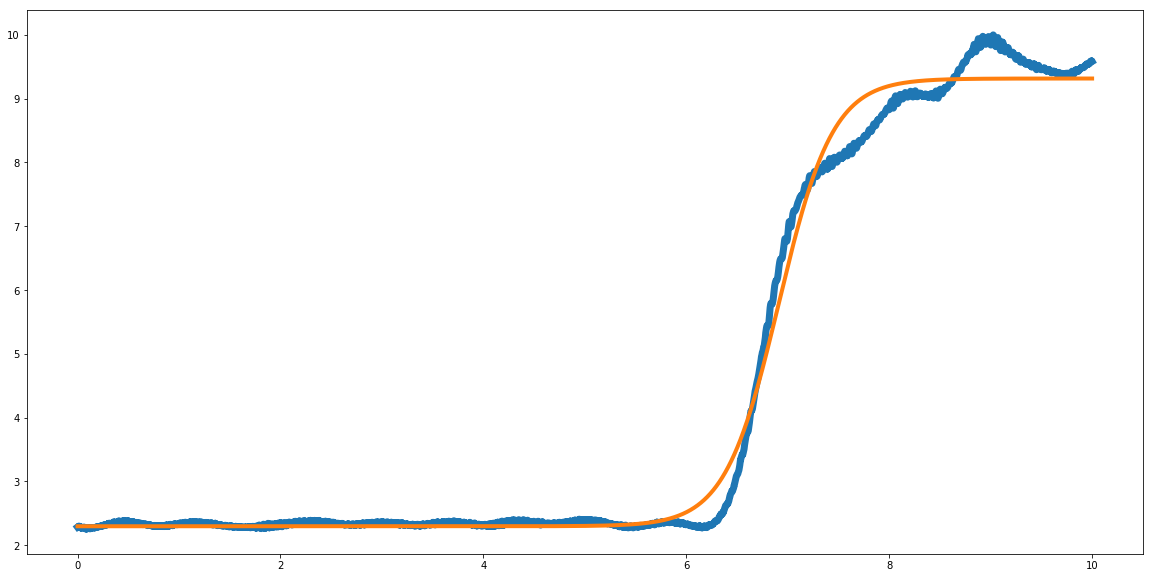

In [26]:
compare_reg = logistic_curve(example_descent, regress_x)

plt.figure(figsize=(20,10))
plt.plot(regress_x,to_regress, linewidth = 7)
plt.plot(regress_x,compare_reg, linewidth = 4)
plt.savefig("Example_regress_epoch0.png")
plt.show()